# Twitter US Airline Sentiment

## Description

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from
February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

## Load Libraries

In [1]:
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(color_codes=True)

### Load dataset

In [2]:
df = pd.read_csv('Tweets.csv')

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.shape

(14640, 15)

In [4]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [7]:
sentiment_df = df[['text', 'airline_sentiment']]

sentiment_df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [8]:
sentiment_df.shape

(14640, 2)

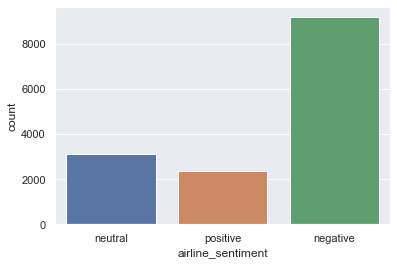

In [67]:
sns.countplot(sentiment_df['airline_sentiment'])

## Text Pre-processing

In [27]:
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/otseobande/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [29]:
import unicodedata
import nltk
import re
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    
    return re.sub(pattern, '', text)

def tokenize(text):
    tokenizer = ToktokTokenizer()
    
    return tokenizer.tokenize(text)

def to_lowercase(words):      
    return [word.lower() for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    
    return [lemmatizer.lemmatize(word, pos='v') for word in words]

def preprocess_text(text):
    processed_text = strip_html_tags(text)
    processed_text = remove_special_characters(processed_text, remove_digits=True)
    
    processed_words = tokenize(processed_text)
    processed_words = lemmatize_verbs(processed_words)
    processed_words = to_lowercase(processed_words)
    
    processed_text = " ".join(processed_words)
    
    return processed_text

In [33]:
sentiment_df['preprocessed_text'] = sentiment_df['text'].apply(preprocess_text)

In [34]:
sentiment_df['preprocessed_text'].head()

0                      virginamerica what dhepburn say
1    virginamerica plus youve add commercials to th...
2    virginamerica i didnt today must mean i need t...
3    virginamerica its really aggressive to blast o...
4    virginamerica and its a really big bad thing a...
Name: preprocessed_text, dtype: object

## Vectorization

### Count Vectorizer

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
count_vectorized_features = vectorizer.fit_transform(sentiment_df['preprocessed_text'])

count_vectorized_features = count_vectorized_features.toarray()

In [39]:
count_vectorized_features.shape

(14640, 1000)

### Tf-Idf Vectorizer

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer()
tf_idf_vectorized_features = tf_idf_vectorizer.fit_transform(sentiment_df['preprocessed_text'])

tf_idf_vectorized_features = tf_idf_vectorized_features.toarray()

In [41]:
tf_idf_vectorized_features.shape

(14640, 13262)

## Train models

In [56]:
text_labels = sentiment_df['airline_sentiment']
set(text_labels)

{'negative', 'neutral', 'positive'}

In [57]:
label_mappings = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}

labels = [label_mappings[label_text] for label_text in text_labels]
set(labels)

{-1, 0, 1}

## Model with Count Vectorized Data

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(count_vectorized_features, labels, test_size=0.3, random_state=42)

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model_with_cv = RandomForestClassifier(n_estimators=10, n_jobs=4)

model_with_cv = forest.fit(X_train, y_train)

print(model_with_cv)

print(np.mean(cross_val_score(model_with_cv, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7106557377049181


In [62]:
model_with_cv_result = model_with_cv.predict(X_test)

### Confusion matrix

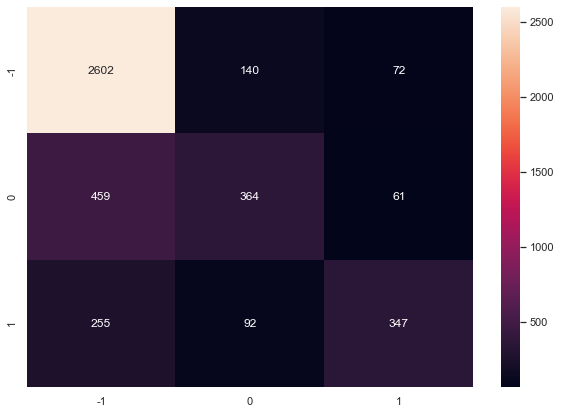

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, model_with_cv_result)

df_cm = pd.DataFrame(
    conf_mat, 
    index = [i for i in ['-1', '0', '1']],
    columns = [i for i in ['-1', '0', '1']]
)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

### Precision

In [70]:
from sklearn.metrics import precision_score

precision_score(y_test, model_with_cv_result, average='weighted')

0.739910577086214

### Recall

In [72]:
from sklearn.metrics import recall_score

recall_score(y_test, model_with_cv_result, average='weighted')

0.7543260473588342

## Model with TF-IDF Vectorized Data

In [74]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_vectorized_features, labels, test_size=0.3, random_state=42)

In [79]:
model_with_tf_idf = RandomForestClassifier(n_estimators=10, n_jobs=4)

model_with_tf_idf = forest.fit(X_train, y_train)

print(model_with_tf_idf)

print(np.mean(cross_val_score(model_with_tf_idf, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7146857923497268


In [76]:
model_with_tf_idf_result = model_with_tf_idf.predict(X_test)

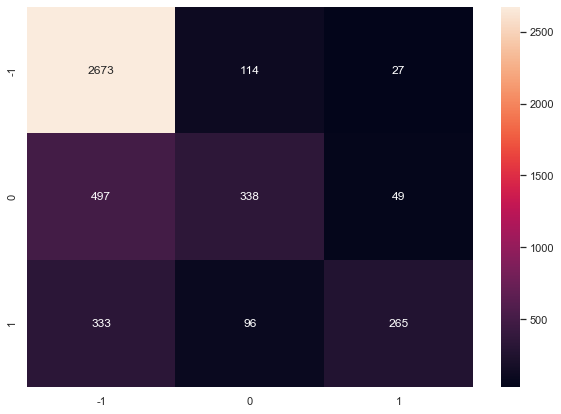

In [78]:
conf_mat = confusion_matrix(y_test, model_with_tf_idf_result)

df_cm = pd.DataFrame(
    conf_mat, 
    index = [i for i in ['-1', '0', '1']],
    columns = [i for i in ['-1', '0', '1']]
)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

### Precision

In [81]:
precision_score(y_test, model_with_tf_idf_result, average='weighted')

0.7358419598871303

### Recall

In [82]:
recall_score(y_test, model_with_tf_idf_result, average='weighted')

0.7459016393442623

## Summary

- The model built with features vectorized using the Count Vectorizer had a slightly better accuracy using cross validation but the model built with the TD-IDF features has a slightly higher Precision and Recall score.
- Due to the Precision and Recall score being higher with the model trained with features vectorized with TD-IDF might be seen as a better model to use for this analysis.
